In [74]:
# Imports
import random
import sys
import numpy as np
import time as t
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

import model
from keijzer_exogan import *

# initialize random seeds
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)


"""
Local variables
"""
workers = 0 # Number of workers for dataloader, 0 when to_vram is enabled
batch_size = 1 # using one image ofcourse
image_size = 32
nz = 100 # size of latent vector
n_iters = 1000 # number of iterations to do for inpainting
torch.backends.cudnn.benchmark=True # Uses udnn auto-tuner to find the best algorithm to use for your hardware, speeds up training by almost 50%
lr = 1e-1
lr_G = 2e-4
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
selected_gpus = [0] # Number of GPUs available. Use 0 for CPU mode.

In [75]:
path = '/datb/16011015/ExoGAN_data/selection//' #notice how you dont put the last folder in here...
images = np.load(path+'last_chunks_25_percent_images.npy')

len(images)

1250000

In [76]:
print('Batch size: ', batch_size)


# Number of training epochs

# Learning rate for optimizers
ngpu = len(selected_gpus)
print('Number of GPUs used: ', ngpu)


"""
Load data and prepare DataLoader
"""
shuffle = True

if shuffle:
    np.random.shuffle(images) # shuffles the images

images = images[:10] # 1200 should take ~ 1 hour
#images = images[:int(len(images)*0.005)]
print('Number of images: ', len(images))

Batch size:  1
Number of GPUs used:  1
Number of images:  10


In [77]:
dataset = numpy_dataset(data=images, to_vram=True) # to_vram pins it to all GPU's
#dataset = numpy_dataset(data=images, to_vram=True, transform=transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])) # to_vram pins it to all GPU's

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=False)

"""
Load and setup models
"""
# Initialize cuda
device = torch.device("cuda:"+str(selected_gpus[0]) if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Load models, set to evaluation mode since training is not needed (this also allows batchsize 1 to work with batchnorm2d layers)
netG = model.Generator(ngpu).eval().to(device)
netD = model.Discriminator(ngpu).eval().to(device)

# Apply weights
print('Loading weights...')
try:
    # Load saved weights
    netG.load_state_dict(torch.load('netG_state_dict', map_location=device)) #net.module..load_... for parallel model , net.load_... for single gpu model
    netD.load_state_dict(torch.load('netD_state_dict', map_location=device))
except:
    print('Could not load saved weights.')
    sys.exit()

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, device_ids=selected_gpus, output_device=device)
    netD = nn.DataParallel(netD, device_ids=selected_gpus, output_device=device)


"""
Define input training stuff (fancy this up)
"""
G = netG
D = netD
z = torch.randn(1, nz, 1, 1, requires_grad=True, device=device)

lamb = 3e-1

criteria = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)) # should be sgd
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))

print('done')

Loading weights...
done


# Show a generated image

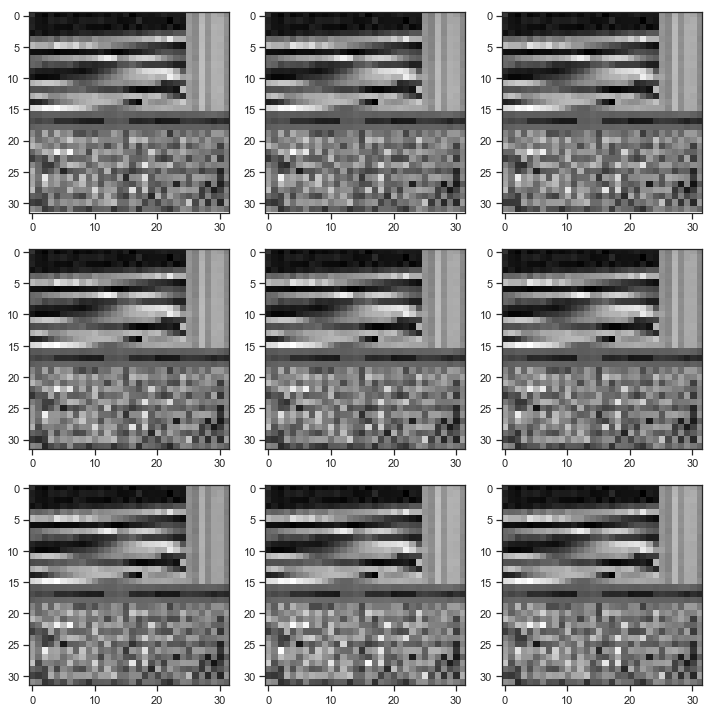

In [139]:
z_tests = [torch.randn(1, nz, 1, 1, device=device) for _ in range(9)]

# TODO: why does this already look real?
plt.figure(figsize=(10,10))
for i in range(9):
    t = G(z_tests[i]).detach().cpu()[0, 0, :, :]
    plt.subplot(3,3,i+1)
    plt.imshow(t, cmap='gray') # plot the masked image

plt.tight_layout()

In [144]:
for z_t in z_tests:
    z_t.detach().cpu().numpy()

# Inpainting
The corrupted image $y$ is mapped to the closest $z$ in the latent representation space, this mapping is denoted as $\hat{z}$.
    
$\hat{z} = \operatorname{arg\,min}_z \{ \mathcal{L}_c(z |y, M) + \mathcal{L}_p (z) \}$

where

$\mathcal{L}_c(z |y, M) = || M \bigodot G(z) - M \bigodot y||_1 = || M \bigodot (G(z)-y) ||_1 $

with $\mathcal{L}_c$ being contextual loss and $M$ being a binary mask with the same size as $y$,

$\mathcal{L}_p (z) = \lambda \operatorname{log}(1-D(G(z)))$

with $\mathcal{L}_p$ being perceptual loss and $D$ being the discriminator.
  
Once $G(\hat{z})$ is generated, the final solution $\hat{x}$ is calculated as

$\hat{x} = \operatorname{arg\, min}_x ||\nabla x - \nabla G(\hat{z}) ||^2_2$  

(substitute $x_i = y_i$ for $M_i = 1$).

-----

$|| ... ||$ is done by `torch.norm()`.  
$... \bigodot ...$ is done by `torch.mul()`.  
-----
TODO: Implement $\hat{x} = \operatorname{arg\, min}_x ||\nabla x - \nabla G(\hat{z}) ||^2_2$    
Currently $\hat{x} = G(\hat{z}) \bigodot (1 -M)+y$

In [79]:
# Lists to keep track of progress
real_images = []
masked_images= []
inpainted_images = []
final_inpainted_images = [] # last inpainted image for each input image

In [80]:
"""
Inpainting
"""
for i, data in enumerate(dataloader, 0): # batches per epoch
    real_cpu = data.to(device)
    b_size = real_cpu.size(0) # this is one ofc, it's one image we're trying to inpaint

    #print("data.shape: ", data.shape)
    image = data.to(device) # select the image (Channel, Height, Width), this is the original unmasked input image
    real_images.append(image)
    #print("image.shape: ", image.shape)

    """Mask the images manually, for testing pruposes"""
    mask = torch.ones(size=image.shape).to(device) # create mask with 1's in the shape of image
    
    #print("mask.shape", mask.shape)

    # use a random 'easy' mask
    mask[:, :, :16, 25:] = 0
    
    # The noise doesn't matter for conceptual loss
    mask[:, :, 19:, :] = 0

    masked_image = torch.mul(image, mask).to(device) #image bigodot mask
    masked_images.append(masked_image)
    #print('masked image shape', masked_image.shape)
    #plt.imshow(masked_image.detach().cpu()[0, 0, :, :], cmap='gray') # plot the masked image

    opt = optim.Adam([z], lr=lr)

    # what's v and m?
    v = torch.tensor(0, dtype=torch.float32, device=device)
    m = torch.tensor(0, dtype=torch.float32, device=device)


    """Start the inpainting process"""
    for iteration in range(n_iters):
        if z.grad is not None:
            z.grad.data.zero_()

        G.zero_grad()
        D.zero_grad()


        image_generated = G(z) # generated image G(z)
        image_generated_masked = torch.mul(image_generated, mask) # G(z) bigodot M
        image_generated_inpainted = torch.mul(image_generated, (1-mask))+masked_image
        
        if (iteration % 100 == 0):
            inpainted_images.append(image_generated_inpainted)

        #print("image_generated_inpainted.shape : ",image_generated_inpainted.shape)

        t = image_generated_inpainted.detach().cpu()[0, 0, :, :]

        # TODO: why does this already look real?
        #plt.imshow(t, cmap='gray') # plot the masked image 

        """Calculate losses"""
        loss_context = torch.norm(image_generated_masked-masked_image, p=1) #what's p=1?
        discriminator_output = netD(image_generated_inpainted)
        #print("Discriminator output: ", discriminator_output)

        labels = torch.full((b_size,), 1, device=device)
        loss_perceptual = torch.log(1-discriminator_output)
        
        #print(loss_perceptual.data.cpu().numpy().flatten()[0])

        total_loss = loss_context + lamb*loss_perceptual
        
        # grab the values from losses for printing
        loss_perceptual = loss_perceptual.data.cpu().numpy().flatten()[0]
        loss_context = loss_context.data.cpu().numpy().flatten()[0]



        total_loss.backward()
        opt.step()
        
        total_loss = total_loss.data.cpu().numpy().flatten()[0]
        
        print("\r image [{}/{}] iteration : {:4} , context_loss: {:.4f}, perceptual_loss: {:4f}, total_loss: {:4f}".format(i+1, len(images), iteration,loss_context,loss_perceptual, total_loss),end="")
    
    final_inpainted_images.append(image_generated_inpainted.detach().cpu())

 image [10/10] iteration :  999 , context_loss: 119.2063, perceptual_loss: -1.631374, total_loss: 118.716858

In [81]:
print('DONE')

DONE


# Show results

In [82]:
real = real_images[0].detach().cpu()[0, 0, :, :]
real_masked = masked_images[0].detach().cpu()[0, 0, :, :]

#first_generated =inpainted_images[1].detach().cpu()[0, 0, :, :]
last_generated = inpainted_images[-1].detach().cpu()[0, 0, :, :]

# Decoding ASPA
Need to clean this up. Using dicts like this is not clean.

In [83]:
aspa_inpainted = last_generated.numpy()
aspa_real = real.numpy()

aspa_inpainted.shape

(32, 32)

In [84]:
# Initialize ExoGAN params with zero's
inpainted_params = {
    'planet_mass': 0,
    'temp_profile': 0,
    'ch4_mixratio': 0,
    'planet_radius': 0,
    'h2o_mixratio': 0,
    'co2_mixratio': 0,
    'co_mixratio': 0
}

real_params = inpainted_params.copy()
params_errors = inpainted_params.copy()

## Inverse scale functions

In [85]:
def inverse_scale_param(X_scaled, X_min, X_max):
    return (X_scaled * (X_max-X_min)) + X_min

def inverse_scale_params(params):
    """
    Inverse scales the params array. 
    Params must be in fixed order, same order as it is encoded with.
    """
    params = params.copy()
    min_values = [1.518400e+27, 
                  1.000000e+03, 
                  -1.842068e+01, 
                  5.592880e+07, 
                  -1.842068e+01, 
                  -1.842068e+01, 
                  -1.842068e+01]
    
    max_values = [3.796000e+27, 
                  2.000000e+03, 
                  -2.302585e+00, 
                  1.048665e+08, 
                  -2.302585e+00, 
                  -2.302585e+00,
                  -2.302585e+00]

    params_inverse_scaled = []
    for i in range(len(params)):
        param = params[i]
        min_= min_values[i]
        max_ = max_values[i]

        params_inverse_scaled.append(inverse_scale_param(param, min_, max_))
    
    return params_inverse_scaled

## Inpainted params

In [86]:
inpainted_params_values = [aspa_inpainted[:16, 25+i:26+i] for i in range(len(inpainted_params))]
inpainted_params_mean  = [i.mean() for i in inpainted_params_values]

inpainted_params_mean

[0.78204894, 0.73794544, 0.8556313, 0.7581478, 0.8371228, 0.8307327, 0.751208]

In [87]:
y = (0.5876265 * (-2.306--1.842068e+01))+-1.842068e+01
y

-8.95126699298

In [88]:
inpainted_params_mean = inverse_scale_params(inpainted_params_mean)
inpainted_params_mean

[3.2995946672439575e+27,
 1737.9454374313354,
 -4.62953355272621,
 93030808.42376351,
 -4.92785521571815,
 -5.030851370071769,
 -6.31263797300309]

### Convert mixtures from log back to regular scale

In [89]:
for i,param in enumerate(inpainted_params):
    if 'mixratio' in param:
        inpainted_params[param] = 10**(inpainted_params_mean[i]) # convert log back to regular scale
    else:
        inpainted_params[param] = inpainted_params_mean[i]

In [90]:
inpainted_params

{'planet_mass': 3.2995946672439575e+27,
 'temp_profile': 1737.9454374313354,
 'ch4_mixratio': 2.3467479506125843e-05,
 'planet_radius': 93030808.42376351,
 'h2o_mixratio': 1.1807141943352502e-05,
 'co2_mixratio': 9.314265858960693e-06,
 'co_mixratio': 4.868128427945849e-07}

## Real params
Ground truth params

In [91]:
real_params_values = [aspa_real[:16, 25+i:26+i] for i in range(len(real_params))]
real_params_mean  = [i.mean() for i in real_params_values]
real_params_mean

[1.0, 0.8888889, -4.6156345e-08, 0.44444445, 0.3333333, 0.44444442, 0.8888889]

In [92]:
real_params_mean = inverse_scale_params(real_params_mean)
real_params_mean

[3.796e+27,
 1888.8888955116272,
 -18.420680743952346,
 77678889.05093968,
 -13.047981986904443,
 -11.257082649205923,
 -4.09348433769852]

### Convert mixtures from log back to regular scale

In [93]:
for i,param in enumerate(real_params):
    if 'mixratio' in param:
        real_params[param] = 10**(real_params_mean[i]) # convert log back to regular scale
    else:
        real_params[param] = real_params_mean[i]

In [94]:
real_params

{'planet_mass': 3.796e+27,
 'temp_profile': 1888.8888955116272,
 'ch4_mixratio': 3.7959392732622775e-19,
 'planet_radius': 77678889.05093968,
 'h2o_mixratio': 8.954019030823769e-14,
 'co2_mixratio': 5.5324481293046354e-12,
 'co_mixratio': 8.063352803300718e-05}

## Percentage error

% error = $\frac{y-\hat{y}}{\hat{y}} \cdot$ 100

In [95]:
percentage_errors = []
for param in real_params:
    y_hat = real_params[param]
    y = inpainted_params[param]
    
    params_errors[param] = ((y - y_hat) / y_hat)*100

params_errors

{'planet_mass': -13.077063560485838,
 'temp_profile': -7.991124223291439,
 'ch4_mixratio': 6182258939552850.0,
 'planet_radius': 19.763309646146546,
 'h2o_mixratio': 13186415857.691175,
 'co2_mixratio': 168356939.07686502,
 'co_mixratio': -99.3962649847154}

## Print results

In [96]:
for param in inpainted_params:
    real = real_params[param]
    inpainted = inpainted_params[param]
    error = params_errors[param]
    
    print('%s \t Real value: %.5e \t inpainted value: %.5e \t perc. diff.: %.25f' % (param, real, inpainted, error))

planet_mass 	 Real value: 3.79600e+27 	 inpainted value: 3.29959e+27 	 perc. diff.: -13.0770635604858380673931606
temp_profile 	 Real value: 1.88889e+03 	 inpainted value: 1.73795e+03 	 perc. diff.: -7.9911242232914387884079588
ch4_mixratio 	 Real value: 3.79594e-19 	 inpainted value: 2.34675e-05 	 perc. diff.: 6182258939552850.0000000000000000000000000
planet_radius 	 Real value: 7.76789e+07 	 inpainted value: 9.30308e+07 	 perc. diff.: 19.7633096461465456172845734
h2o_mixratio 	 Real value: 8.95402e-14 	 inpainted value: 1.18071e-05 	 perc. diff.: 13186415857.6911754608154296875000000
co2_mixratio 	 Real value: 5.53245e-12 	 inpainted value: 9.31427e-06 	 perc. diff.: 168356939.0768650174140930175781250
co_mixratio 	 Real value: 8.06335e-05 	 inpainted value: 4.86813e-07 	 perc. diff.: -99.3962649847154011695238296


# Functionize this to output the MAPE of all inpainted images per metric 

In [121]:
#real_images = []
#final_inpainted_images = []
reals = []
inpainteds = []
errors = []
for i in range(len(real_images)):
    aspa_real = real_images[i].detach().cpu()[0, 0, :, :].numpy()
    aspa_inpainted = final_inpainted_images[i].detach().cpu()[0, 0, :, :].numpy()

    """Decode inpainted aspa"""
    inpainted_params_values = [aspa_inpainted[:16, 25+i:26+i] for i in range(len(inpainted_params))]
    inpainted_params_mean  = [i.mean() for i in inpainted_params_values]
    inpainted_params_mean = inverse_scale_params(inpainted_params_mean)
    
    for i,param in enumerate(inpainted_params):
        if 'mixratio' in param:
            inpainted_params[param] = inpainted_params_mean[i] # convert log back to regular scale
        else:
            inpainted_params[param] = inpainted_params_mean[i]
    
    """Decode real aspa"""
    real_params_values = [aspa_real[:16, 25+i:26+i] for i in range(len(real_params))]
    real_params_mean  = [i.mean() for i in real_params_values]
    real_params_mean = inverse_scale_params(real_params_mean)
    for i,param in enumerate(real_params):
        if 'mixratio' in param:
            real_params[param] = real_params_mean[i] # convert log back to regular scale
        else:
            real_params[param] = real_params_mean[i]

    """Calculate percentage difference"""
    params_errors = dict.fromkeys(params_errors, 0) # copy dicts' keys, set all values to zero
    for param in real_params:
        y_hat = real_params[param]
        y = inpainted_params[param]
        
        params_errors[param] = ((y - y_hat) / y_hat)*100
    
    reals.append(real_params)
    inpainteds.append(inpainted_params)
    errors.append(params_errors)

# Create one large df from all the dicts

In [122]:
dfs = []
for i in range(len(errors)):
    df1 = pd.DataFrame(errors[i], index=[0])
    df1.columns = [i+'_error' for i in df1.columns]

    df2 = pd.DataFrame(reals[i], index=[0])
    df2.columns = [i+'_real' for i in df2.columns]

    df3 = pd.DataFrame(inpainteds[i], index=[0])
    df3.columns = [i+'_inpainted' for i in df3.columns]

    df = pd.concat([df1, df2, df3], axis=1)
    
    dfs.append(df)

df = pd.concat(dfs)
df

,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,ch4_mixratio_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
0,-27.718284,-21.113949,-54.709730,3.973690,-32.470830,-20.318891,153.411696,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-11.257083,3.300630e+27,1739.132106,-4.625401,9.309114e+07,-4.920627,-5.023893,-6.286149
0,-22.978649,56.634867,70.438475,16.971216,-32.103028,28.228485,303.322947,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-11.257083,3.300630e+27,1739.132106,-4.625401,9.309114e+07,-4.920627,-5.023893,-6.286149
0,-29.990523,30.938342,-46.359925,18.096041,-35.500919,-27.332582,-2.443772,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-11.257083,3.300630e+27,1739.132106,-4.625401,9.309114e+07,-4.920627,-5.023893,-6.286149
0,13.798658,15.834642,32.338342,-3.995412,153.089368,-60.090948,223.081291,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-11.257083,3.300630e+27,1739.132106,-4.625401,9.309114e+07,-4.920627,-5.023893,-6.286149
0,-11.768019,-12.387950,-6.863007,49.712597,-47.021504,0.122892,128.040189,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-11.257083,3.300630e+27,1739.132106,-4.625401,9.309114e+07,-4.920627,-5.023893,-6.286149
0,17.302997,18.876361,190.040231,9.999141,-60.158359,77.055136,-31.423785,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-11.257083,3.300630e+27,1739.132106,-4.625401,9.309114e+07,-4.920627,-5.023893,-6.286149
0,-3.389425,25.940097,-67.423226,-3.795325,-3.486195,-23.514676,-61.118870,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-11.257083,3.300630e+27,1739.132106,-4.625401,9.309114e+07,-4.920627,-5.023893,-6.286149
0,30.712053,43.363433,-59.433348,3.651227,72.292271,-60.537686,-34.613581,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-11.257083,3.300630e+27,1739.132106,-4.625401,9.309114e+07,-4.920627,-5.023893,-6.286149
0,-23.699573,16.785212,-51.074893,25.882652,86.854192,-47.209420,-38.351397,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-11.257083,3.300630e+27,1739.132106,-4.625401,9.309114e+07,-4.920627,-5.023893,-6.286149
0,44.917014,4.347925,-74.890176,-0.957871,-73.287487,118.184906,-44.158275,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-11.257083,3.300630e+27,1739.132106,-4.625401,9.309114e+07,-4.920627,-5.023893,-6.286149


# Errors of all images

In [123]:
df.describe()

,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,ch4_mixratio_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000,...,10.000000,10.000000,1.000000e+01,1.000000e+01,10.000000,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01
mean,-1.281375,17.921898,-6.793726,11.953796,2.820751,-1.541278,59.574644,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-1.125708e+01,3.300630e+27,1739.132106,-4.625401e+00,9.309114e+07,-4.920627e+00,-5.023893e+00,-6.286149e+00
std,26.544602,23.600804,83.762883,16.627288,75.044539,59.531134,131.468608,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,1.872445e-15,0.000000e+00,0.000000,9.362223e-16,0.000000e+00,9.362223e-16,9.362223e-16,9.362223e-16
min,-29.990523,-21.113949,-74.890176,-3.995412,-73.287487,-60.537686,-61.118870,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-1.125708e+01,3.300630e+27,1739.132106,-4.625401e+00,9.309114e+07,-4.920627e+00,-5.023893e+00,-6.286149e+00
25%,-23.519342,7.219604,-58.252444,0.194403,-44.141358,-42.240211,-37.416943,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-1.125708e+01,3.300630e+27,1739.132106,-4.625401e+00,9.309114e+07,-4.920627e+00,-5.023893e+00,-6.286149e+00
50%,-7.578722,17.830787,-48.717409,6.986416,-32.286929,-21.916783,-16.933778,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-1.125708e+01,3.300630e+27,1739.132106,-4.625401e+00,9.309114e+07,-4.920627e+00,-5.023893e+00,-6.286149e+00
75%,16.426913,29.688780,22.538005,17.814835,53.347654,21.202087,147.068819,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-1.125708e+01,3.300630e+27,1739.132106,-4.625401e+00,9.309114e+07,-4.920627e+00,-5.023893e+00,-6.286149e+00
max,44.917014,56.634867,190.040231,49.712597,153.089368,118.184906,303.322947,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-1.125708e+01,3.300630e+27,1739.132106,-4.625401e+00,9.309114e+07,-4.920627e+00,-5.023893e+00,-6.286149e+00


In [124]:
params = [param for param in real_params.keys()]
param = params[2]
print(param)

ch4_mixratio


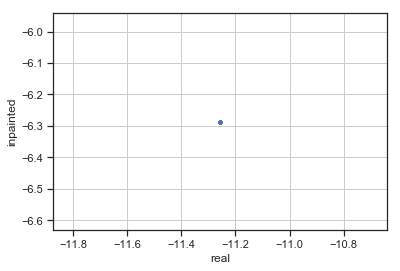

In [133]:
x = df[param+'_real']
y = df[param+'_inpainted']

plt.plot(x, y, '.')
plt.xlabel('real')
plt.ylabel('inpainted')
plt.grid()

In [126]:
x

0   -18.420681
0   -18.420681
0   -18.420681
0   -18.420681
0   -18.420681
0   -18.420681
0   -18.420681
0   -18.420681
0   -18.420681
0   -18.420681
Name: ch4_mixratio_real, dtype: float64

In [127]:
y

0   -4.625401
0   -4.625401
0   -4.625401
0   -4.625401
0   -4.625401
0   -4.625401
0   -4.625401
0   -4.625401
0   -4.625401
0   -4.625401
Name: ch4_mixratio_inpainted, dtype: float64

(array([5., 1., 1., 0., 1., 1., 0., 0., 0., 1.]),
 array([-74.89017573, -48.39713508, -21.90409443,   4.58894621,
         31.08198686,  57.57502751,  84.06806816, 110.56110881,
        137.05414945, 163.5471901 , 190.04023075]),
 <a list of 10 Patch objects>)

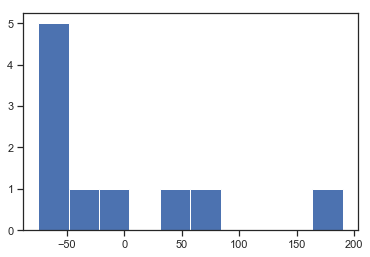

In [128]:
plt.hist(df[param+'_error'])

saved


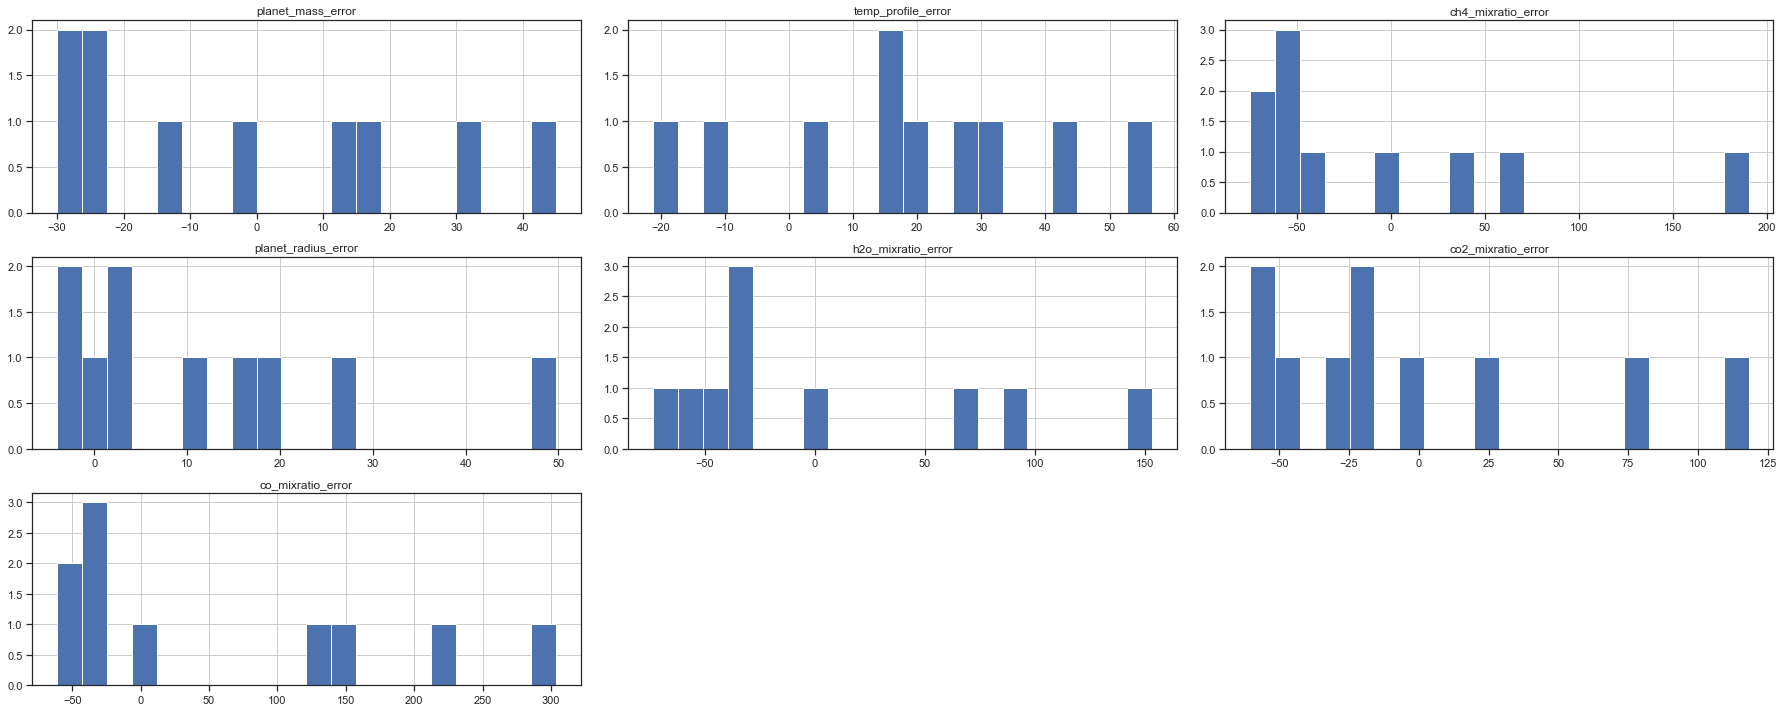

In [129]:
plt.figure(figsize=((25,10)))
for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param+'_error')
    plt.hist(df[param+'_error'], bins=20)
    plt.grid()
    plt.tight_layout()

#plt.savefig('plots//Validation error hist of '+str(len(images))+' images.png', dpi=1200)
print('saved')

In [130]:
#df.to_csv('Validation error of '+str(len(images))+' images')

In [131]:
df.head()

,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,ch4_mixratio_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
0,-27.718284,-21.113949,-54.709730,3.973690,-32.470830,-20.318891,153.411696,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-11.257083,3.300630e+27,1739.132106,-4.625401,9.309114e+07,-4.920627,-5.023893,-6.286149
0,-22.978649,56.634867,70.438475,16.971216,-32.103028,28.228485,303.322947,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-11.257083,3.300630e+27,1739.132106,-4.625401,9.309114e+07,-4.920627,-5.023893,-6.286149
0,-29.990523,30.938342,-46.359925,18.096041,-35.500919,-27.332582,-2.443772,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-11.257083,3.300630e+27,1739.132106,-4.625401,9.309114e+07,-4.920627,-5.023893,-6.286149
0,13.798658,15.834642,32.338342,-3.995412,153.089368,-60.090948,223.081291,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-11.257083,3.300630e+27,1739.132106,-4.625401,9.309114e+07,-4.920627,-5.023893,-6.286149
0,-11.768019,-12.387950,-6.863007,49.712597,-47.021504,0.122892,128.040189,2.277600e+27,1666.666687,-18.420681,...,-18.420681,-2.302585,-11.257083,3.300630e+27,1739.132106,-4.625401,9.309114e+07,-4.920627,-5.023893,-6.286149


In [132]:
print('DONE')

DONE
